# Gaussian Processes Inferencing in Stingray


## Gaussian Processes in Astronomy

Explain Bayesian Analysis, Gaussian Processes, Evidence, use of GPs in Astronomy 


## Sample Lightcurve

Make a sample lightcurve, and fit a Red Noise Kernel gp using a just the dictionary for prior

In [1]:
# Importing the necessary libraries
import numpy as np
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
import seaborn as sns
sns.set_style('whitegrid')

from tinygp import GaussianProcess, kernels
from stingray import Lightcurve

jax.config.update("jax_enable_x64", True)

# May shift the ahead
import tensorflow_probability.substrates.jax as tfp
tfpd = tfp.distributions
tfpb = tfp.bijectors

/opt/homebrew/anaconda3/lib/python3.9/site-packages/stingray/utils.py:25: UserWarning: pyfftw not installed. Using standard scipy fft
  warnings.warn("pyfftw not installed. Using standard scipy fft")


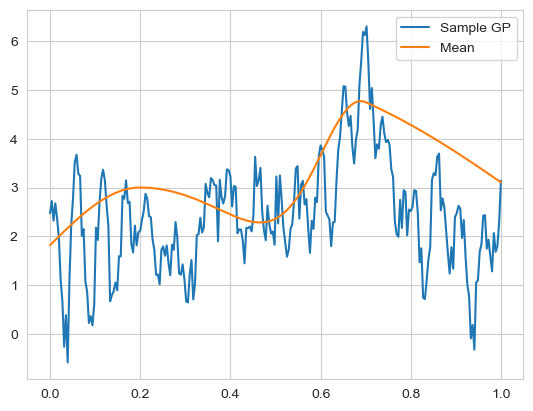

In [146]:
from gpmodelling import get_kernel, get_mean
# suppress warnings
import warnings
warnings.filterwarnings("ignore")

Times = np.linspace(0,1,256)

# ------------------------------------------- Combo 1
# kernel_params  = {"arn" : jnp.exp(1.0),    "crn" : jnp.exp(1.0),
#                   "aqpo": jnp.exp(-2),    "cqpo": jnp.exp(1),    "freq": 20,}
# kernel = get_kernel(kernel_type = "QPO_plus_RN", kernel_params = kernel_params)

# mean_params = {
#     "A" : 3,    "t0" : 0.5,    "sig" : 0.2,
# }

# mean = get_mean(mean_type = "gaussian",  mean_params = mean_params)
# -------------------------------------------

# mean_params = {"A" : jnp.array([3.0, 4.0]), "t0" : jnp.array([0.2, 0.7]), 
#                "sig1" : jnp.array([0.2, 0.1]), "sig2" : jnp.array([0.3, 0.4]),  }

# mean = get_mean(mean_type = "skew_gaussian",  mean_params = mean_params)

kernel_params  = {"arn" : jnp.exp(1.5),    "crn" : jnp.exp(1.0),
                  "aqpo": jnp.exp(-0.4),    "cqpo": jnp.exp(1),    "freq": 20,}
kernel = get_kernel(kernel_type = "QPO_plus_RN", kernel_params = kernel_params)

mean_params = {"A" : jnp.array([3.0, 4.0]), "t0" : jnp.array([0.2, 0.7]), 
               "sig1" : jnp.array([0.2, 0.1]), "sig2" : jnp.array([0.3, 0.4]),  }

mean = get_mean(mean_type = "skew_gaussian",  mean_params = mean_params)

jit = 5e-2
gp = GaussianProcess(kernel = kernel, X = Times, mean_value = mean(Times), diag = jit)
# gp = GaussianProcess(kernel = kernel, X = Times, mean = mean, diag = 5e-2)

# Plotting the GP
key = 6
fig, ax = plt.subplots()
ax.plot(Times, gp.sample(key = jax.random.PRNGKey(key), shape= (1,)).T, label = "Sample GP")
ax.plot(Times, mean(Times), label = "Mean"); ax.legend()

plt.show()

INFO[2023-07-11 16:14:47,107]: Checking if light curve is well behaved. This can take time, so if you are sure it is already sorted, specify skip_checks=True at light curve creation.
INFO[2023-07-11 16:14:47,108]: Checking if light curve is sorted.


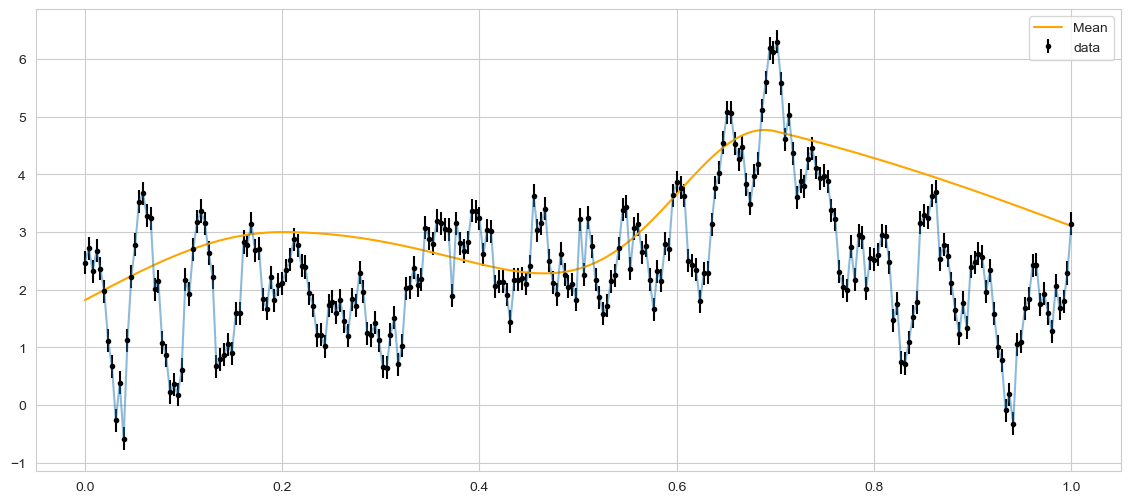

In [147]:
counts = sample = gp.sample(key = jax.random.PRNGKey(key))
yerr = (0.2)*np.ones_like(Times)
fig, ax = plt.subplots(1,1, figsize = (14,6))
plt.errorbar(Times, sample.T, yerr=yerr, fmt=".k", capsize=0, label="data")
ax.plot(Times, mean(Times), color = "orange" ,label = "Mean"); ax.legend()
ax.plot(Times, gp.sample(key = jax.random.PRNGKey(key), shape= (1,)).T, label = "Sample GP", alpha = 0.5)

lc = Lightcurve(time = Times, counts = counts, dt = Times[1]- Times[0])

In [148]:
from gpmodelling import get_prior, get_likelihood, get_gp_params

params_list = get_gp_params(kernel_type= "RN", mean_type = "gaussian")
print(params_list)

counts = sample
T = Times[-1] - Times[0]
f = 1/(Times[1]- Times[0])
span = jnp.max(counts) - jnp.min(counts)

# Can make multi mean A, sid, t0(the problem)
prior_dict = {
    "A": tfpd.Uniform(low = 0.1 * span, high = 2 * span),
    "t0": tfpd.Uniform(low = Times[0] - 0.1*T, high = Times[-1] + 0.1*T),
    "sig": tfpd.Uniform(low = 0.5 * 1 / f, high = 2 * T),
    "arn": tfpd.Uniform(low = 0.1 * span, high = 2 * span),
    "crn": tfpd.Uniform(low = jnp.log(1 / T), high = jnp.log(f)),
}
# prior_dict = {
#     "A": tfpd.TransformedDistribution( distribution = tfpd.Uniform(low = 0.1 * span, high = 2 * span), 
#                                       bijector=tfp.bijectors.Invert(tfp.bijectors.Exp()) ),
#     "t0": tfpd.Uniform(low = Times[0] - 0.1*T, high = Times[-1] + 0.1*T),
#     # "t0": tfpd.TransformedDistribution( distribution = tfpd.Uniform(low = Times[0] - 0.1*T, high = Times[-1] + 0.1*T), 
#     #                                   bijector=tfp.bijectors.Invert(tfp.bijectors.Exp()) ),
#     "sig": tfpd.TransformedDistribution( distribution = tfpd.Uniform(low = 0.5 * 1 / f, high = 2 * T),
#                                         bijector=tfp.bijectors.Invert(tfp.bijectors.Exp()) ),
#     "arn": tfpd.TransformedDistribution( distribution = tfpd.Uniform(low = 0.1 * span, high = 2 * span),
#                                         bijector=tfp.bijectors.Invert(tfp.bijectors.Exp()) ),
#     "crn": tfpd.TransformedDistribution( distribution = tfpd.Uniform(low = jnp.log(1 / T), high = jnp.log(f)),
#                                         bijector=tfp.bijectors.Invert(tfp.bijectors.Exp()) ),
# }
prior_model = get_prior(params_list, prior_dict)
for a in prior_model():
    print(a)

likelihood_model = get_likelihood(params_list, kernel_type= "RN", mean_type = "gaussian", Times = Times, counts = counts, yerr = yerr)

['arn', 'crn', 'A', 't0', 'sig']
arn	() -> () <class 'numpy.float64'>
crn	() -> () <class 'numpy.float64'>
A	() -> () <class 'numpy.float64'>
t0	() -> () <class 'numpy.float64'>
sig	() -> () <class 'numpy.float64'>


In [149]:
from gpmodelling import GPResult

Gpresult = GPResult(Lightcurve(time = Times, counts = counts, dt = Times[1]- Times[0]))
Gpresult.sample(prior_model = prior_model, likelihood_model = likelihood_model)

INFO[2023-07-11 16:15:12,440]: Checking if light curve is well behaved. This can take time, so if you are sure it is already sorted, specify skip_checks=True at light curve creation.
INFO[2023-07-11 16:15:12,442]: Checking if light curve is sorted.
INFO[2023-07-11 16:15:12,760]: Sanity check...
INFO[2023-07-11 16:15:12,763]: Sanity check passed


Simulation Complete


Evidence:  -214.29253215981748


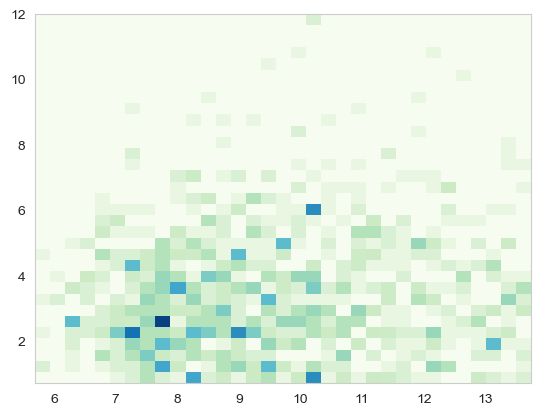

In [150]:
print("Evidence: ", Gpresult.get_evidence())
Gpresult.corner_plot("A", "arn", n1 = 0, n2 = 0)

--------
Termination Conditions:
Small remaining evidence
--------
# likelihood evals: 314414
# samples: 4652
# slices: 123000.0
# slices / acceptance: 41.0
# likelihood evals / sample: 67.6
# likelihood evals / slice: 2.5
--------
logZ=-214.293 +- 0.079
H=210.0
ESS=1055
--------
A: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
A: 3.2 +- 1.7 | 1.2 / 2.8 / 5.3 | 2.7 | 2.7
--------
arn: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
arn: 9.4 +- 1.9 | 7.3 / 9.0 / 12.4 | 7.0 | 7.0
--------
crn: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
crn: 4.3 +- 0.78 | 3.16 / 4.37 / 5.33 | 5.52 | 5.52
--------
sig: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
sig: 1.12 +- 0.55 | 0.36 / 1.14 / 1.83 | 1.11 | 1.11
--------
t0: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
t0: 0.55 +- 0.34 | 0.05 / 0.58 / 1.0 | 0.96 | 0.96
--------


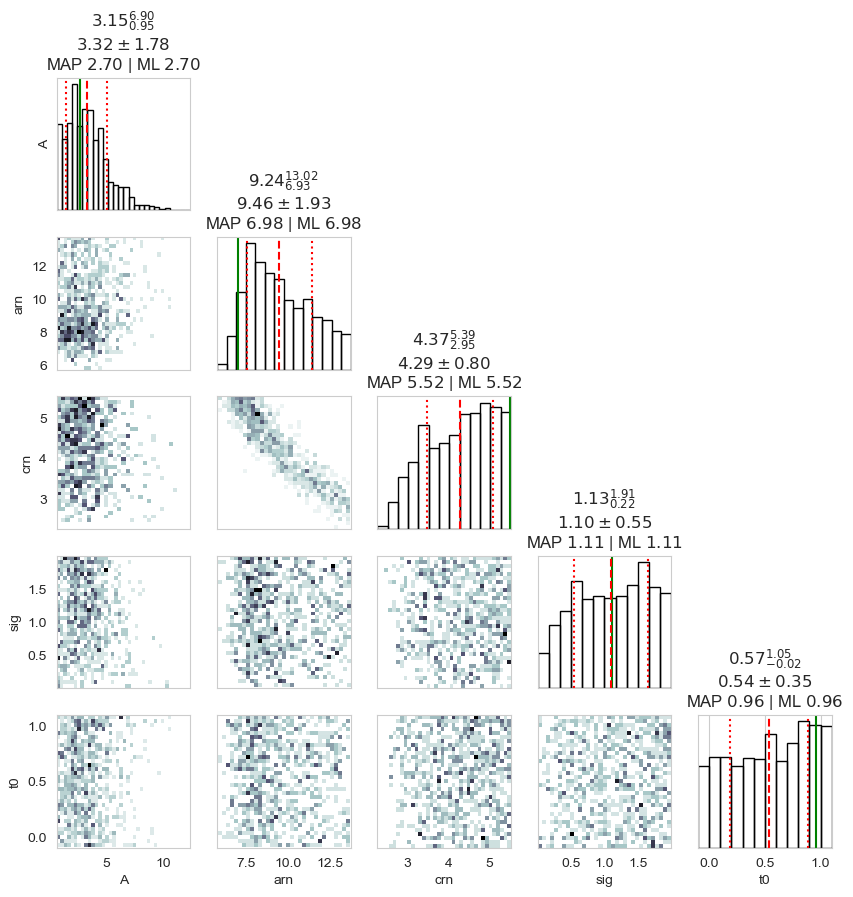

In [151]:
Gpresult.print_summary()
Gpresult.plot_cornerplot()

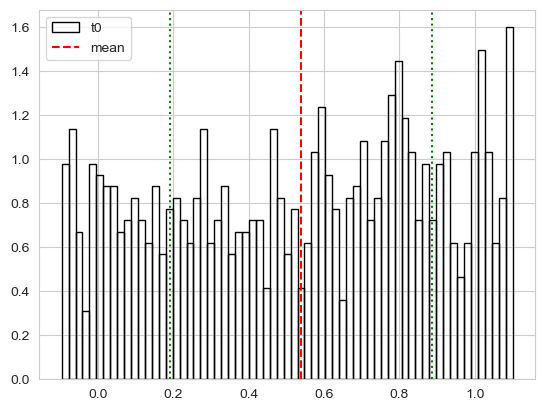

In [152]:
Gpresult.weighted_posterior_plot("t0")

## Making own priors and log_likelihood functions

In [160]:
# QPO prior
from jaxns import Prior
from jaxns.special_priors import ForcedIdentifiability
from jaxns.types import float_type

params_list3 = get_gp_params(kernel_type= "QPO_plus_RN", mean_type = "gaussian")
print(params_list3)

counts = sample
T = Times[-1] - Times[0]
f = 1/(Times[1]- Times[0])
span = jnp.max(counts) - jnp.min(counts)

# Can make multi mean A, sid, t0 with n = 2

def prior_model3():
    arn = yield Prior(tfpd.Uniform(low = 0.1 * span, high = 2 * span), name='arn')
    crn = yield Prior(tfpd.Uniform(low = jnp.log(1 / T), high = jnp.log(f)), name='crn')
    aqpo = yield Prior(tfpd.Uniform(low = 0.1 * span, high = 2 * span), name='aqpo')
    cqpo = yield Prior(tfpd.Uniform(low = 1/10/T, high = jnp.log(f)), name='cqpo')
    freq = yield Prior(tfpd.Uniform(low = 2 , high = f/4 ), name='freq')

    n = 2
    A = yield Prior(tfpd.Uniform(low = 0.1 * span*jnp.ones(n), high = 2 * span*jnp.ones(n)), name='A')
    
    # t0 = []
    # scale_bij = tfp.bijectors.Scale(scale = Times[-1] - Times[0])
    # shift_bij = tfp.bijectors.Shift(shift= Times[0])
    # for i in range(n):
    #     underlying_beta = tfpd.Beta(
    #         concentration1=jnp.asarray(1., float_type),
    #         concentration0=jnp.asarray(n - i, float_type)
    #     )
    #     t = yield Prior(shift_bij(scale_bij(underlying_beta)), name=f"t{i}")
    #     # Updating the shift and scale here
    #     scale_bij = tfp.bijectors.Scale(scale= Times[-1] - t)
    #     shift_bij = tfp.bijectors.Shift(shift=t)
    #     t0.append(t)
    # t0 = jnp.stack(t0)
    t0 = yield ForcedIdentifiability(n = n, low = Times[0] - 0.1*T, high = Times[-1] + 0.1*T, name='t0')
    sig = yield Prior(tfpd.Uniform(low = 0.5 * 1 / f *jnp.ones(n), high = 2 * T *jnp.ones(n)), name='sig')

    return arn, crn, aqpo, cqpo, freq, A, t0, sig


likelihood_model3 = get_likelihood(params_list3, kernel_type= "QPO_plus_RN", mean_type = "gaussian", Times = Times, counts = counts)

['arn', 'crn', 'aqpo', 'cqpo', 'freq', 'A', 't0', 'sig']


In [161]:
Gpresult3 = GPResult(Lightcurve(time = Times, counts = counts, dt = Times[1]- Times[0]))
Gpresult3.sample(prior_model = prior_model3, likelihood_model = likelihood_model3)

INFO[2023-07-11 16:36:58,945]: Checking if light curve is well behaved. This can take time, so if you are sure it is already sorted, specify skip_checks=True at light curve creation.
INFO[2023-07-11 16:36:58,949]: Checking if light curve is sorted.
INFO[2023-07-11 16:37:00,000]: Sanity check...
INFO[2023-07-11 16:37:00,007]: Sanity check passed


Simulation Complete


Evidence:  -204.0424729376019


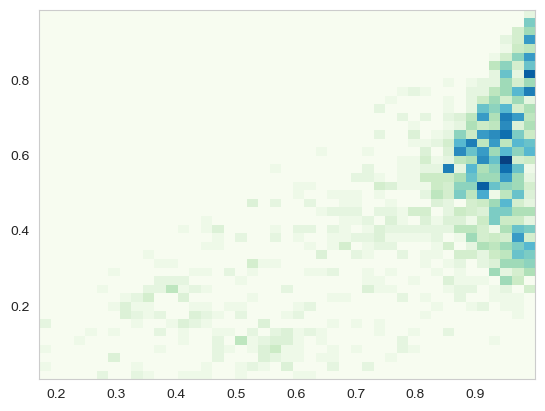

In [155]:
print("Evidence: ", Gpresult3.get_evidence())
# Gpresult3.corner_plot("t0", "t0", n1 = 0, n2 = 1)
Gpresult3.corner_plot("t0", "t1")

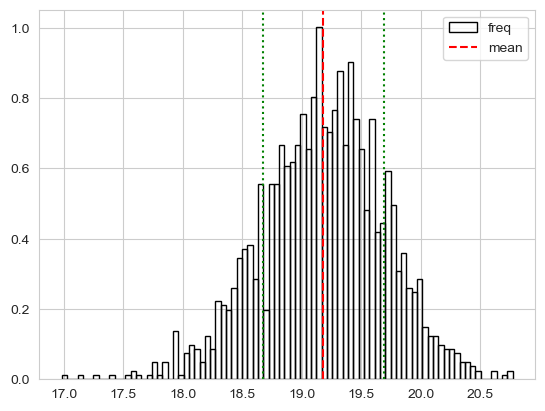

In [159]:
Gpresult3.weighted_posterior_plot("freq")

--------
Termination Conditions:
Small remaining evidence
--------
# likelihood evals: 619069
# samples: 8652
# slices: 238000.0
# slices / acceptance: 34.0
# likelihood evals / sample: 71.6
# likelihood evals / slice: 2.6
--------
logZ=-204.04 +- 0.14
H=200.0
ESS=1815
--------
A[#]: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
A[0]: 3.0 +- 1.5 | 1.1 / 2.9 / 5.0 | 1.0 | 1.0
A[1]: 3.4 +- 1.5 | 1.6 / 3.3 / 5.2 | 1.6 | 1.6
--------
aqpo: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
aqpo: 1.13 +- 0.62 | 0.72 / 0.94 / 1.73 | 0.8 | 0.8
--------
arn: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
arn: 10.8 +- 2.0 | 7.8 / 11.2 / 13.1 | 6.5 | 6.5
--------
cqpo: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
cqpo: 1.63 +- 0.84 | 0.58 / 1.62 / 2.61 | 1.47 | 1.47
--------
crn: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
crn: 2.79 +- 0.71 | 2.12 / 2.57 / 3.65 | 4.49 | 4.49
--------
f

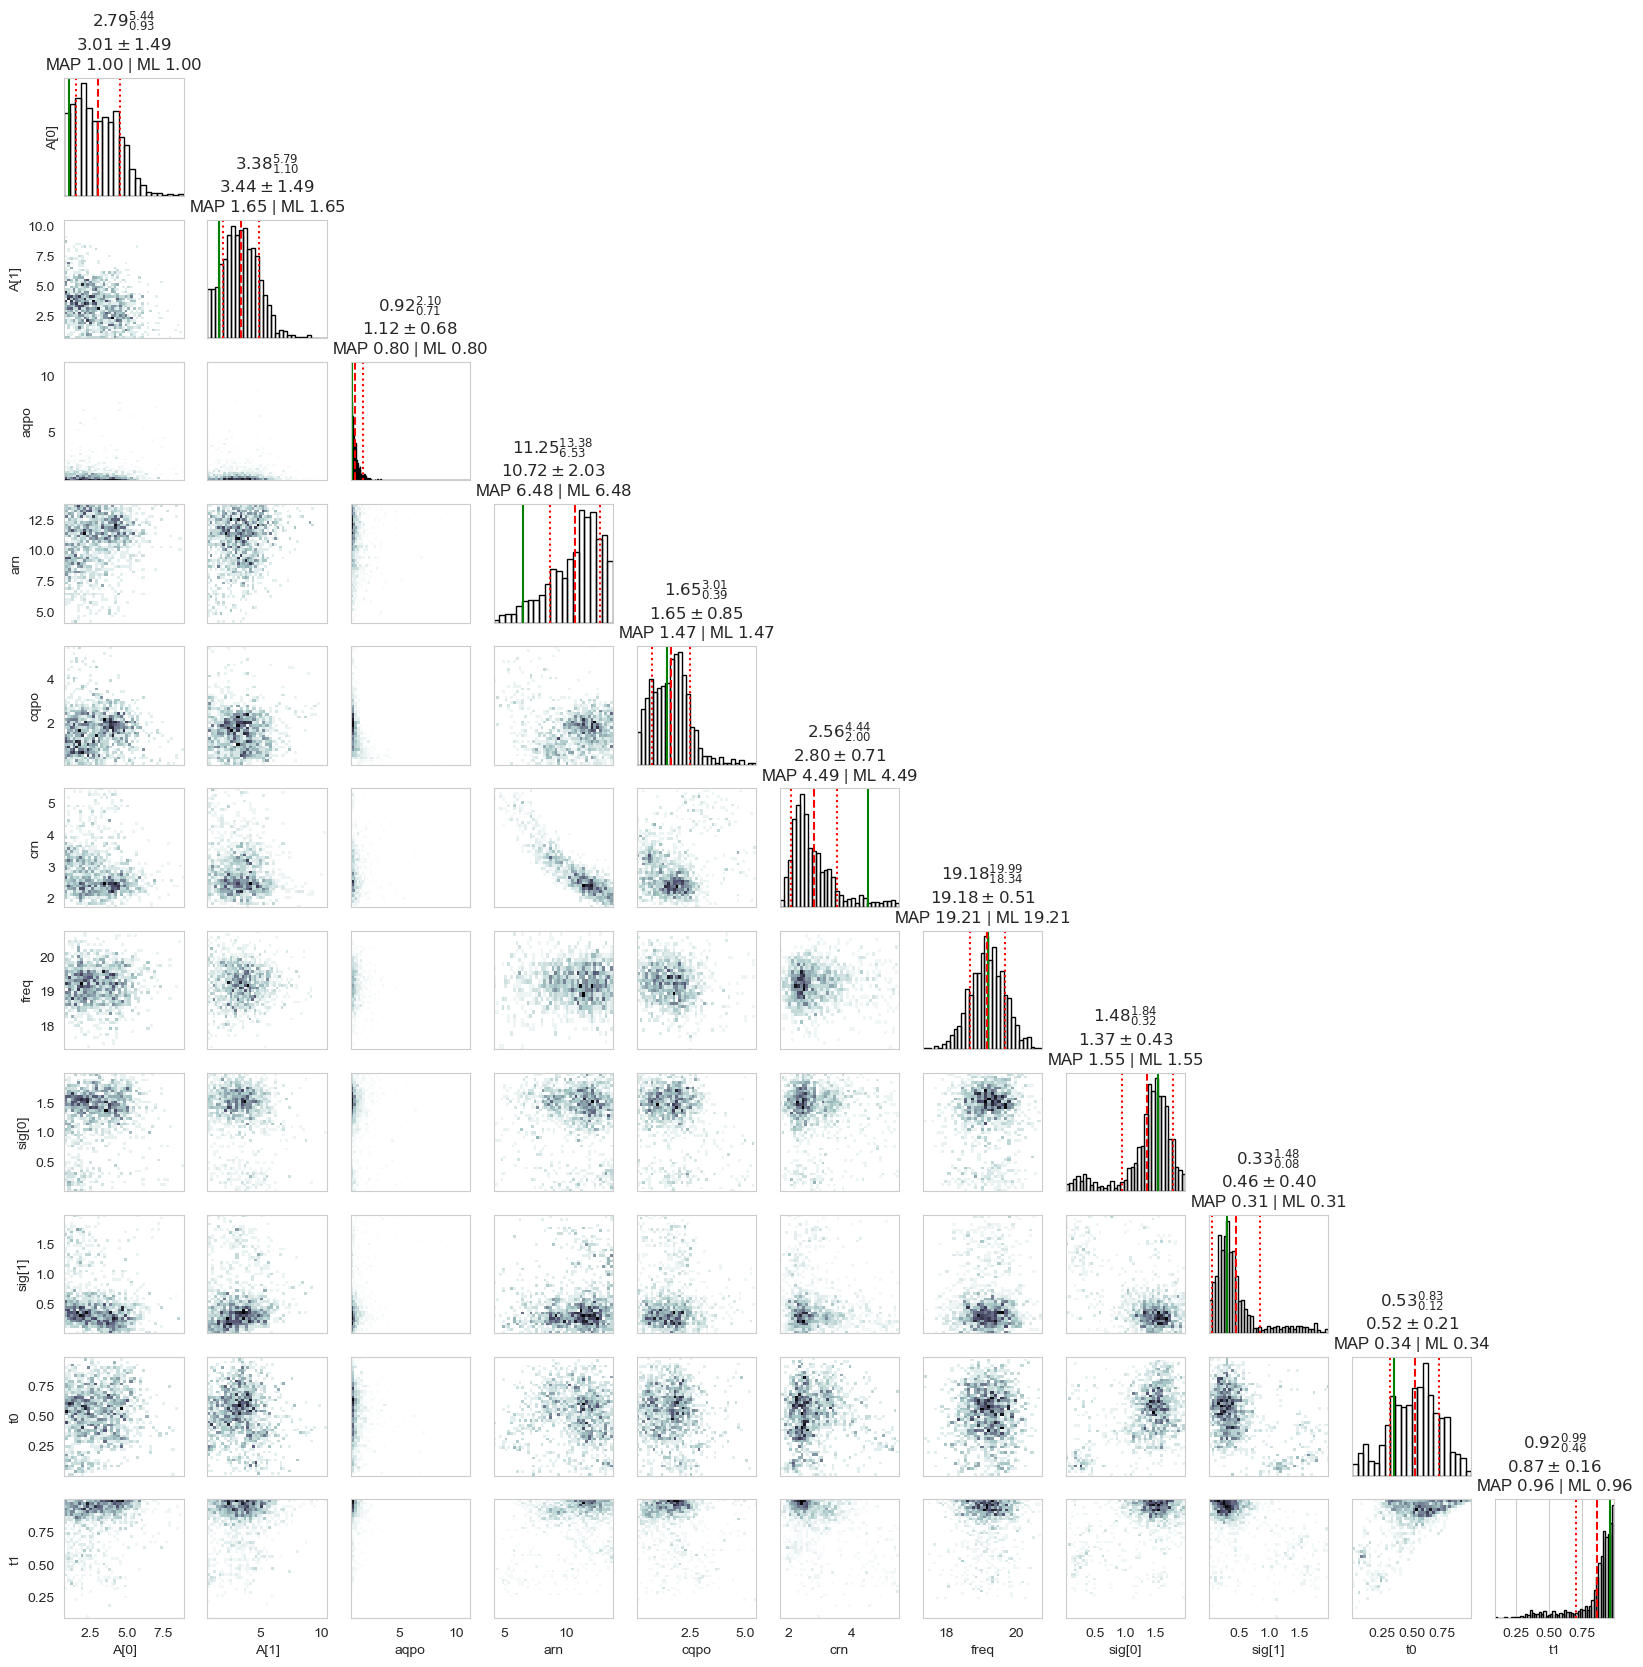

In [157]:
Gpresult3.print_summary()
Gpresult3.plot_cornerplot()